# Build Model

### Initial Plan for Model Building
1. Import Libraries
2. Read Pickle
3. Data Processing
4. Model Preparing
5. Model Building and Evaluation
   - XGBoost
   - CatBoost
   - Logistic Regression
   - Random Forest
   - Neural Network
9. Model Performance Comparison

### Build Models:
- **XGBoost**: An efficient and scalable implementation of gradient boosting, which builds an ensemble of decision trees by iteratively minimizing a loss function.
- **XGBoost with threshold**: XGBoost model with an additional step where a probability threshold is applied to convert predicted probabilities into class labels for binary classification.
- **CatBoost**: A gradient boosting algorithm that `handles categorical features efficiently` and is designed to reduce overfitting while maintaining high accuracy.
- **CatBoost with threshold**: CatBoost model with a probability threshold applied to the predicted probabilities to determine the final class labels for binary classification.
- **Logistic Regression**: A linear model for binary classification that estimates the probability of a binary outcome using a logistic function.
- **Random Forest**: An ensemble method that uses bagging, where `multiple decision trees are built independently`, and their results are averaged (`regression: mean prediction`) or voted on (`classification: mode of the classes`).
- **Neural Network**: consisting of layers of interconnected nodes (neurons) that can capture complex patterns in data through nonlinear transformations and training.

## 1. Import Libraries

In [90]:
# Load general utilities
# ----------------------
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from datetime import date
import os
import io, time, joblib

# Load scikit-learn utilities, and KS evaluation
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, classification_report, recall_score, f1_score, precision_score, confusion_matrix
from scipy.stats import ks_2samp

# Classifiers, Regression, Cross-Validation, and Over-Sampling
# --------------
from xgboost import XGBClassifier # XGBoost Classifier ouperformces 
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna # For hyperparameter tuning, Optuna surpasses GridSearchCV by using Bayesian optimization to efficiently explore and find the best parameters.
from imblearn.over_sampling import RandomOverSampler

# Internal utility functions and 
# --------------
import a0_utility_functions as func # Visulization 
import shap

plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")

## 2. Read Pickle

In [91]:
# define pickle path
today = (date.today()).strftime("%Y%m%d")
pkl_path = os.path.join('/pkl_objects/', today)
print(pkl_path)

/pkl_objects/20240708


In [92]:
# Read the data and features from the pickle
pkl_file = pkl_path + '/final_data.pkl'
df, categorical_features, continuous_features = pickle.load( open( pkl_file, "rb" ) )

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 786362 entries, 541899 to 108114
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   accountNumber                   786362 non-null  object        
 1   creditLimit                     786362 non-null  float64       
 2   availableMoney                  786362 non-null  float64       
 3   transactionDateTime             786362 non-null  datetime64[ns]
 4   transactionAmount               786362 non-null  float64       
 5   merchantName                    786362 non-null  object        
 6   acqCountry                      786362 non-null  object        
 7   merchantCountryCode             786362 non-null  object        
 8   posEntryMode                    786362 non-null  object        
 9   posConditionCode                786362 non-null  object        
 10  merchantCategoryCode            786362 non-null  object 

In [94]:
df = df.drop(columns = ["time_diff","is_multi_swipe"])


In [95]:
df.head()

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,transactionMonth,transactionHour,transactionDayOfWeek,accountAgeInMonths,daysSinceLastAddressChange,cardExpirationInMonths,CVV_Match,flag_reversed,flag_multi_swipe,flag_duplicated
541899,100088067,50000.0,50000.00,2016-01-12 00:59:52,205.13,EZ Putt Putt #982199,US,US,02,01,...,1,0,1,24,733,148,1,False,False,False
541900,100088067,50000.0,49794.87,2016-01-12 19:49:41,46.43,Dinosaur Sandwitch Bar #303701,US,US,05,01,...,1,19,1,24,733,98,1,False,False,False
541901,100088067,50000.0,49748.44,2016-01-17 15:41:46,378.67,Mobile eCards,US,US,05,01,...,1,15,6,24,738,192,1,False,False,False
541902,100088067,50000.0,50000.00,2016-02-02 19:57:18,66.07,EZ Putt Putt #40513,US,US,02,01,...,2,19,1,25,754,143,1,False,False,False
541903,100088067,50000.0,49933.93,2016-02-03 04:48:54,141.60,34th BBQ #412895,US,US,09,08,...,2,4,2,25,755,179,1,False,False,False


In [96]:
# Print the unique values for columns less than 20 unique values
for i in df.columns:
    if df[i].nunique() < 20:
        print(i, df[i].unique())
        print('-'*20)

creditLimit [50000.  5000. 20000.   250.  1000.  2500.  7500. 10000.   500. 15000.]
--------------------


acqCountry ['US' 'CAN' 'MEX' 'PR' 'UNKNOWN']
--------------------
merchantCountryCode ['US' 'CAN' 'MEX' 'PR' 'UNKNOWN']
--------------------
posEntryMode ['02' '05' '09' '00' '80' '90']
--------------------
posConditionCode ['01' '08' '99' '00']
--------------------
merchantCategoryCode ['entertainment' 'food' 'online_gifts' 'mobileapps' 'online_retail' 'fuel'
 'rideshare' 'fastfood' 'online_subscriptions' 'hotels' 'cable/phone'
 'auto' 'personal care' 'health' 'furniture' 'airline' 'subscriptions'
 'food_delivery' 'gym']
--------------------
cardPresent [ True False]
--------------------
transactionType ['PURCHASE' 'REVERSAL' 'ADD_VERI' 'UNKNOWN']
--------------------
expirationDateKeyInMatch [False  True]
--------------------
isFraud [False  True]
--------------------
transactionMonth [ 1  2  3  4  5  6  7  8  9 10 11 12]
--------------------
transactionDayOfWeek [1 6 2 0 5 3 4]
--------------------
CVV_Match [1 0]
--------------------
flag_reversed [False  True]
--------------------

## 3. Data Processing

### Notes about the Dataset

**Note 1:**
- 'echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd' are empty columns and should be handled appropriately.

**Note 2:**
- 'posEntryMode', 'posConditionCode', 'merchantCountryCode', 'acqCountry', 'transactionType' contain some empty strings that were replaced and then dropped.

**Encoding Categorical Columns:**
- Several categorical columns were encoded numerically to facilitate modeling.

In [97]:
# Convert object types to applicable types for the model building
df.accountNumber =df.accountNumber.astype(int) # Covert object datatype to int
encoder = LabelEncoder()
df.merchantName = encoder.fit_transform(df.merchantName) # Covert categorical classes to number so model can work with it
df.acqCountry = encoder.fit_transform(df.acqCountry) # Covert categorical classes to number so model can work with it
df.merchantCountryCode = encoder.fit_transform(df.merchantCountryCode) # Covert categorical classes to number so model can work with it
df.posEntryMode = encoder.fit_transform(df.posEntryMode) # Covert categorical classes to number so model can work with it
df.posConditionCode = encoder.fit_transform(df.posConditionCode) # Covert categorical classes to number so model can work with it
df.merchantCategoryCode = encoder.fit_transform(df.merchantCategoryCode) # convert categorical classes to number so model can work with it
df.cardCVV = encoder.fit_transform(df.cardCVV) # Covert categorical classes to number so model can work with it
df.enteredCVV = encoder.fit_transform(df.enteredCVV) # Covert categorical classes to number so model can work with it
df.cardLast4Digits = encoder.fit_transform(df.cardLast4Digits) # Covert categorical classes to number so model can work with it
df.transactionType = encoder.fit_transform(df.transactionType) # Covert categorical classes to number so model can work with it
df.cardPresent = df.cardPresent.astype(int) # Covert from from pool to int for the model 
df.expirationDateKeyInMatch = df.expirationDateKeyInMatch.astype(int) # Covert from from pool to int for the model
df.isFraud = df.isFraud.astype(int) # Covert from from pool to int for the model 
df.flag_reversed  = df.flag_reversed.astype(int) # Covert from from pool to int for the model 
df.flag_multi_swipe  = df.flag_multi_swipe.astype(int) # Covert from from pool to int for the model 
df.flag_duplicated  = df.flag_duplicated.astype(int) # Covert from from pool to int for the model 

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 786362 entries, 541899 to 108114
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   accountNumber                   786362 non-null  int32         
 1   creditLimit                     786362 non-null  float64       
 2   availableMoney                  786362 non-null  float64       
 3   transactionDateTime             786362 non-null  datetime64[ns]
 4   transactionAmount               786362 non-null  float64       
 5   merchantName                    786362 non-null  int32         
 6   acqCountry                      786362 non-null  int32         
 7   merchantCountryCode             786362 non-null  int32         
 8   posEntryMode                    786362 non-null  int32         
 9   posConditionCode                786362 non-null  int32         
 10  merchantCategoryCode            786362 non-null  int32  

In [99]:
# Print the unique values for columns less than 20 unique values
for i in df.columns:
    if df[i].nunique() < 20:
        print(i, df[i].unique())
        print('-'*20)

creditLimit [50000.  5000. 20000.   250.  1000.  2500.  7500. 10000.   500. 15000.]
--------------------
acqCountry [4 0 1 2 3]
--------------------
merchantCountryCode [4 0 1 2 3]
--------------------
posEntryMode [1 2 3 0 4 5]
--------------------
posConditionCode [1 2 3 0]
--------------------
merchantCategoryCode [ 3  5 13 12 14  7 17  4 15 11  2  1 16 10  8  0 18  6  9]
--------------------
cardPresent [1 0]
--------------------
transactionType [1 2 0 3]
--------------------
expirationDateKeyInMatch [0 1]
--------------------
isFraud [0 1]
--------------------
transactionMonth [ 1  2  3  4  5  6  7  8  9 10 11 12]
--------------------
transactionDayOfWeek [1 6 2 0 5 3 4]
--------------------
CVV_Match [1 0]
--------------------
flag_reversed [0 1]
--------------------
flag_multi_swipe [0 1]
--------------------
flag_duplicated [0 1]
--------------------


### Heatmap Visualization of the correlation matrix

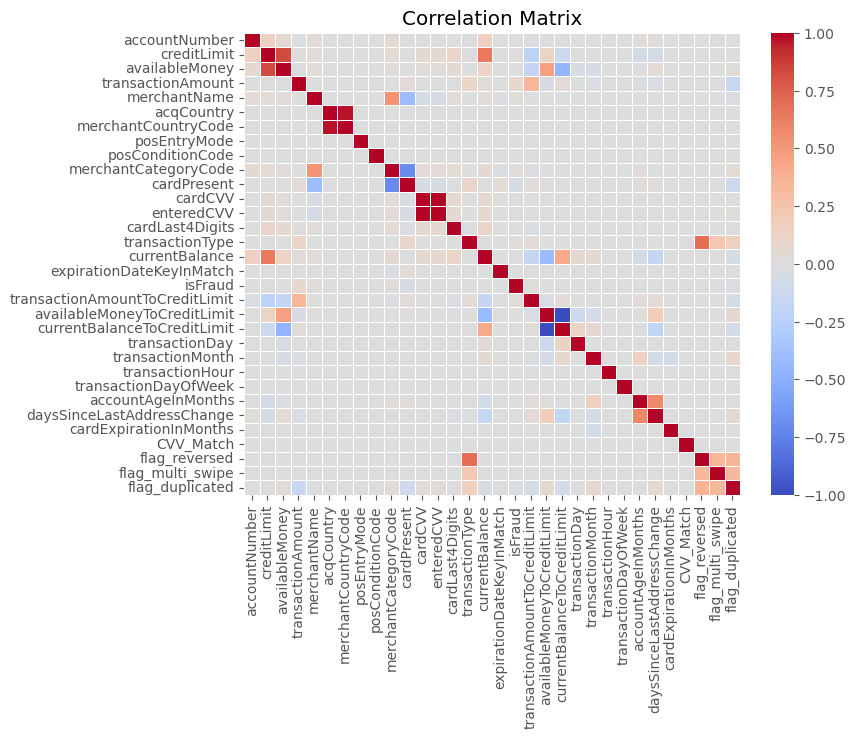

In [100]:
# Drop non-numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [101]:
numeric_df.corr()

,accountNumber,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,transactionMonth,transactionHour,transactionDayOfWeek,accountAgeInMonths,daysSinceLastAddressChange,cardExpirationInMonths,CVV_Match,flag_reversed,flag_multi_swipe,flag_duplicated
accountNumber,1.000000,0.140674,0.066345,-0.001364,0.031605,0.003145,0.003462,-0.001015,-0.000341,0.048011,...,-0.000057,0.000931,0.000275,0.010663,0.022676,-0.000700,0.004877,-0.000867,0.001095,-0.005925
creditLimit,0.140674,1.000000,0.834977,0.005581,0.039103,0.000990,0.001481,-0.001710,-0.000516,0.045094,...,-0.001247,-0.001529,-0.000283,-0.061540,-0.062468,0.001472,0.001343,0.001827,0.001825,-0.010631
availableMoney,0.066345,0.834977,1.000000,-0.010070,0.026237,0.000956,0.001609,-0.001275,-0.000714,0.017699,...,-0.038478,-0.003186,0.000683,-0.020999,0.041593,0.004844,-0.000583,-0.003377,-0.002066,0.021838
transactionAmount,-0.001364,0.005581,-0.010070,1.000000,-0.000445,-0.000411,-0.000384,0.001520,0.001721,-0.005222,...,-0.029303,0.001338,0.000474,-0.007875,-0.028431,0.002076,0.000701,0.002202,0.006529,-0.151085
merchantName,0.031605,0.039103,0.026237,-0.000445,1.000000,0.000235,0.000619,-0.000369,-0.003029,0.529880,...,0.001647,0.000757,-0.002553,0.006728,0.009075,0.000512,-0.001514,-0.000568,0.000453,-0.021081
acqCountry,0.003145,0.000990,0.000956,-0.000411,0.000235,1.000000,0.969681,0.000986,0.000391,-0.001333,...,-0.000247,0.001137,-0.000439,0.001935,0.003043,0.003632,-0.001316,-0.001720,-0.000933,-0.001830
merchantCountryCode,0.003462,0.001481,0.001609,-0.000384,0.000619,0.969681,1.000000,0.001033,0.000349,-0.001362,...,-0.000881,0.001062,-0.000271,0.002057,0.002933,0.003812,-0.001415,-0.001596,-0.001256,-0.002392
posEntryMode,-0.001015,-0.001710,-0.001275,0.001520,-0.000369,0.000986,0.001033,1.000000,0.000640,0.000726,...,0.001118,-0.001504,0.000527,0.000623,0.001133,-0.002866,-0.000324,-0.000967,0.001131,0.003603
posConditionCode,-0.000341,-0.000516,-0.000714,0.001721,-0.003029,0.000391,0.000349,0.000640,1.000000,-0.000930,...,-0.000236,-0.000770,0.001317,-0.002275,-0.001826,0.001360,-0.001457,-0.000387,0.000748,-0.000467
merchantCategoryCode,0.048011,0.045094,0.017699,-0.005222,0.529880,-0.001333,-0.001362,0.000726,-0.000930,1.000000,...,0.000330,-0.000356,-0.001719,0.016994,-0.003071,-0.000557,-0.001171,-0.001291,-0.001290,0.043308


Text(0.5, 1.0, 'Histgram for the numirical features in the data set')

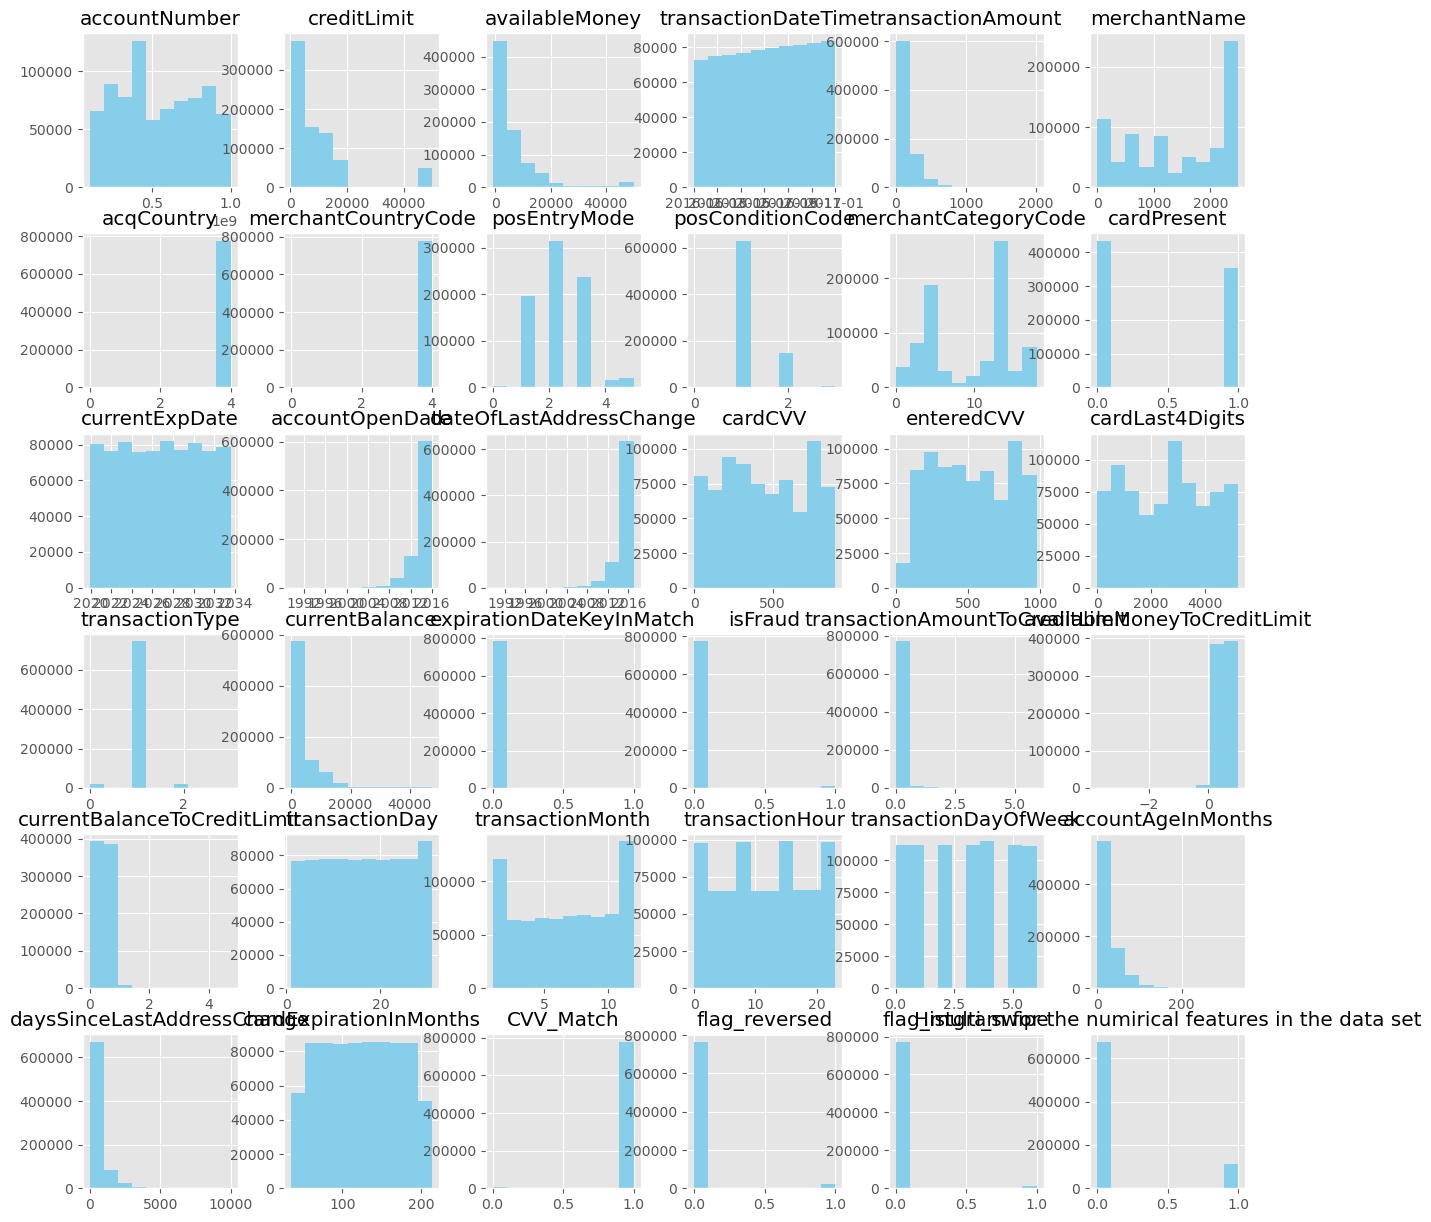

In [102]:
df.hist(figsize=(15,15), color='skyblue')
plt.title('Histgram for the numirical features in the data set')

## 4. Model Preparing

In [103]:
df = df.drop(columns = ["transactionDateTime", "currentExpDate", "accountOpenDate","dateOfLastAddressChange","enteredCVV", "cardCVV","cardLast4Digits"])

In [104]:
# Split The Data And Also Drop datetime because model can't use it
X = df.drop(columns = ['isFraud'])
y = df['isFraud']

In [105]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 786362 entries, 541899 to 108114
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   accountNumber                   786362 non-null  int32  
 1   creditLimit                     786362 non-null  float64
 2   availableMoney                  786362 non-null  float64
 3   transactionAmount               786362 non-null  float64
 4   merchantName                    786362 non-null  int32  
 5   acqCountry                      786362 non-null  int32  
 6   merchantCountryCode             786362 non-null  int32  
 7   posEntryMode                    786362 non-null  int32  
 8   posConditionCode                786362 non-null  int32  
 9   merchantCategoryCode            786362 non-null  int32  
 10  cardPresent                     786362 non-null  int32  
 11  transactionType                 786362 non-null  int32  
 12  currentBalance  

In [106]:
# Save X Columns Name 
X_columns= X.columns

In [107]:
# Use MinMax to Standardize features by removing the mean and scaling to unit variance and help speeding the process ** NOTE I TRIED StandardScaler AND NONE SCALING AND THIS IS THE BEST
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [108]:
# Split data to train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Oversampling for Balanced Fraud Detection
 #### **Fraud data is imbalanced**: few frauds vs many normal transactions. This can trick models into:

 1. **Missing Fraud**: Focusing on the common (normal) pattern, the model misses the rare (fraudulent) one.
Misleading Accuracy: High overall accuracy might hide poor fraud detection.
Oversampling balances the data by increasing the minority class (fraud) samples. This helps the model:

 2. **Learn Fraud Patterns**: With more fraud data, the model can better understand what fraud looks like.
Improve Detection: A balanced model is more likely to catch fraudulent transactions.

In [109]:
print(df.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.value_counts())
print(pd.Series(y_train).mean())

(786362, 29)
(629089, 28)
(629089,)
(157273, 28)
(157273,)
isFraud
0    619148
1      9941
Name: count, dtype: int64
0.015802215584758278


In [110]:
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [111]:
print(df.shape)
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())
print(pd.Series(y_train).mean())

(786362, 29)
(1238296, 28)
(1238296,)
isFraud
0    619148
1    619148
Name: count, dtype: int64
0.5


## 5. Model Building

### Hyperparameter Optimization with Optuna for XGBoost Classifier

This code demonstrates how to perform hyperparameter optimization for an XGBoost classifier using the Optuna framework. The goal is to find the best set of hyperparameters that maximizes the accuracy of the model on a validation dataset. The main steps in the code are:

1. **Define the Objective Function**: This function specifies the hyperparameters to be optimized and how to evaluate the model's performance.
2. **Hyperparameter Search Space**: The hyperparameters to be optimized include:
   - `n_estimators`: Number of trees in the forest.
   - `max_depth`: Maximum depth of the tree.
   - `learning_rate`: Boosting learning rate.
   - `subsample`: Fraction of samples to be used for fitting the individual base learners.
   - `colsample_bytree`: Fraction of features to be used for fitting the individual base learners.
   - `reg_alpha`: L1 regularization term on weights.
   - `reg_lambda`: L2 regularization term on weights.
3. **Training and Evaluation**: The model is trained on the training data and evaluated on the test data using accuracy as the metric.
4. **Perform Hyperparameter Optimization**: Optuna's `study` object is created and optimized over a specified number of trials.
5. **Print the Best Parameters**: The best set of hyperparameters found during the optimization process is printed.
6. **Train the Final Model**: Using the best hyperparameters, a final XGBoost classifier is trained and evaluated on the test set.
7. **Evaluation Metrics**: The model's performance is evaluated using accuracy and AUC (Area Under the Curve) on the test set.

In [112]:
# If True I will re choose the best parameter and it will take huge amount of time and computer process 
# we don't need I already did it once 
hyperparametertuning = False 

In [113]:
if hyperparametertuning:
    # Define objective function for Optuna
    def objective(trial):
        # Define hyperparameters to search
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'verbosity': 0,
        'tree_method':'gpu_hist' # If you run the code without a GPU a error will happen remove 'tree_method':'gpu_hist' and the code will run 
        }

        xgb = XGBClassifier(**param)

        # Fit the model on training data
        xgb.fit(X_train, y_train)

        # Predict on the validation set
        y_pred = xgb.predict(X_test)

        score = recall_score(y_test, y_pred)

        return score

    # Perform hyperparameter optimization using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    # Print the best trial and parameters found
    print("Best trial:")
    best_trial = study.best_trial
    print(f"  Value: {best_trial.value}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    # Use the best parameters to train the final model
    best_params = best_trial.params
else:
    best_params = {'n_estimators': 1126, 'max_depth': 4, 'learning_rate': 0.036900204134713545, 'subsample': 0.6393791462952656, 'colsample_bytree': 0.7801635259304414, 'reg_alpha': 6.135511579551007, 'reg_lambda': 9.730922611121699}

## Train & Evaluate XGBoost Model

### XGBoost Algorithm

[XGBoost](https://xgboost.readthedocs.io/en/latest/) (Extreme Gradient Boosting) is a powerful gradient boosting framework known for its speed, performance, and flexibility:

- **Gradient Boosting Framework:** Sequentially builds an ensemble of weak learners (typically decision trees) to minimize errors.
  
- **Regularization:** Integrates L1 and L2 regularization to prevent overfitting.
  
- **Optimization:** Uses second-order gradient information for faster convergence.

- **Customizable Objectives:** Supports custom objective functions for various supervised learning tasks.

- **Benefits:** Known for speed, scalability, and high performance across different domains like finance, retail, and healthcare.

- **Interpretability:** Provides feature importance scores for understanding model predictions.

- **Usage:** Widely used for tasks like fraud detection, customer churn prediction, and recommendation systems.

- **Implementation:** Easily implemented in Python using the `xgboost` library with `scikit-learn` integration for preprocessing and evaluation.

In [114]:
xgb_normal = XGBClassifier(**best_params)
xgb_normal.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test,y_test)],verbose=0)

# Make predictions on the test set
y_pred_xgb = xgb_normal.predict(X_test)

normal_xgb_acc = accuracy_score(y_test,y_pred_xgb)

print("Test ACC:",normal_xgb_acc )

Test ACC: 0.788031003414445


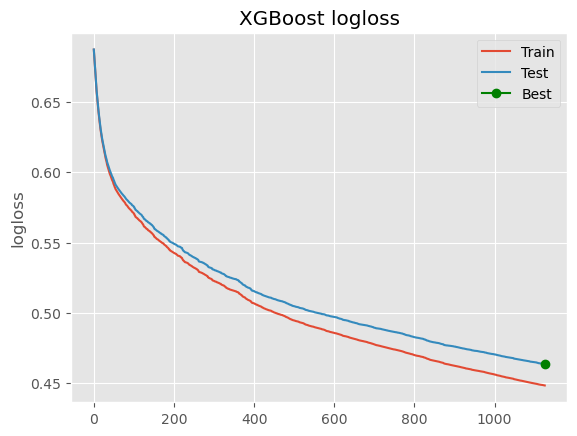

In [115]:
results = xgb_normal.evals_result()
val_logloss = results["validation_1"]['logloss']
best_epopch = min(val_logloss)
i_best_epoch = val_logloss.index(best_epopch)
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
    
# plot m log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.plot(i_best_epoch, best_epopch, marker="o", color="green", label="Best")
ax.legend()
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.show()

Test AUC: 0.7480578399499149

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88    154797
           1       0.05      0.71      0.10      2476

    accuracy                           0.79    157273
   macro avg       0.52      0.75      0.49    157273
weighted avg       0.98      0.79      0.87    157273



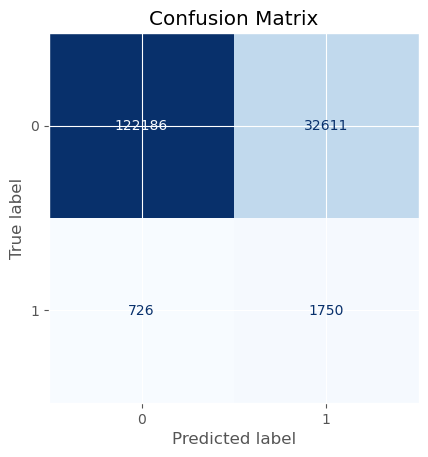

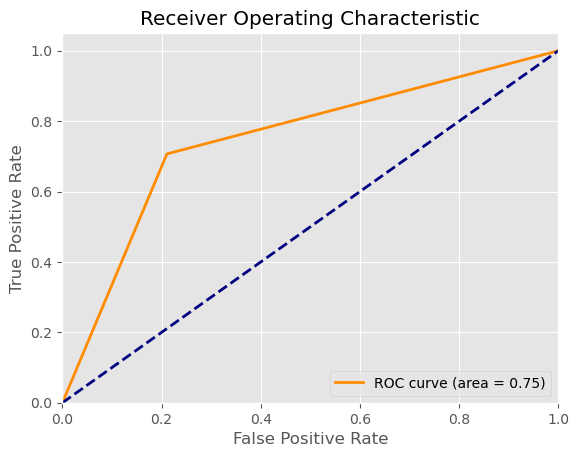

In [116]:
func.evaluate_model(y_test,y_pred_xgb)

In [117]:
model_1 = func.dict_eval(y_test,y_pred_xgb,'XGB')

Optimizing the threshold for fraud detection is crucial for balancing between catching as much fraud as possible (high recall)

- Why Recall is Important in Fraud Detection
- In fraud detection systems, recall plays a critical role in minimizing financial losses and ensuring robust security.

- Recall measures the system's ability to identify actual fraud cases (True Positives) out of all actual fraud attempts.
- A high recall signifies the system catches a significant portion of fraudulent transactions, reducing the chances of letting them slip through.
- Missing fraudulent transactions (False Negatives) can be far more detrimental than inconveniencing legitimate users (False Positives).
- Fraudulent transactions result in financial losses for institutions and potentially expose customer data.


In [118]:
threshold = 0.3 #Adjust as you want 
y_pred_xgb_proba = xgb_normal.predict_proba(X_test)
y_proba = y_pred_xgb_proba[:, 1]
y_pred_xgb_t = (y_proba >=threshold ).astype(int)

print(f"Recall : {recall_score(y_test,y_pred_xgb_t)}")
print(f"Accuracy: {accuracy_score(y_test,y_pred_xgb_t)}")

Recall : 0.8893376413570274
Accuracy: 0.5445181308934146


Test AUC: 0.7141701676038417

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.54      0.70    154797
           1       0.03      0.89      0.06      2476

    accuracy                           0.54    157273
   macro avg       0.51      0.71      0.38    157273
weighted avg       0.98      0.54      0.69    157273



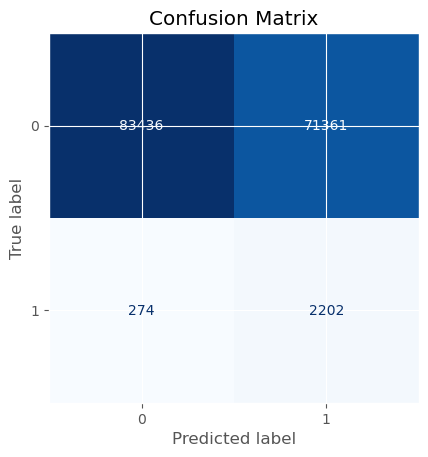

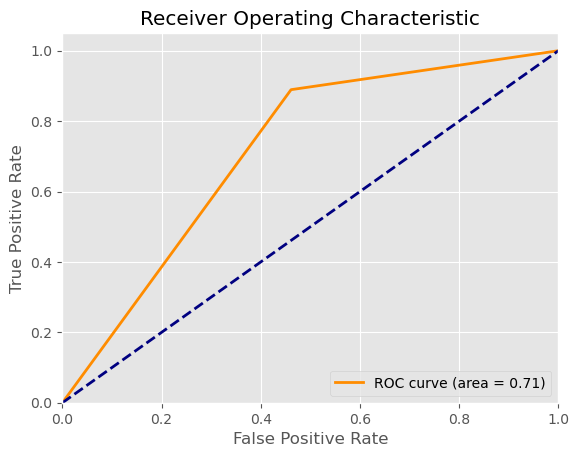

In [119]:
func.evaluate_model(y_test, y_pred_xgb_t)

In [123]:
model_2 = func.dict_eval(y_test,y_pred_xgb_t,'XGB_Threshold')

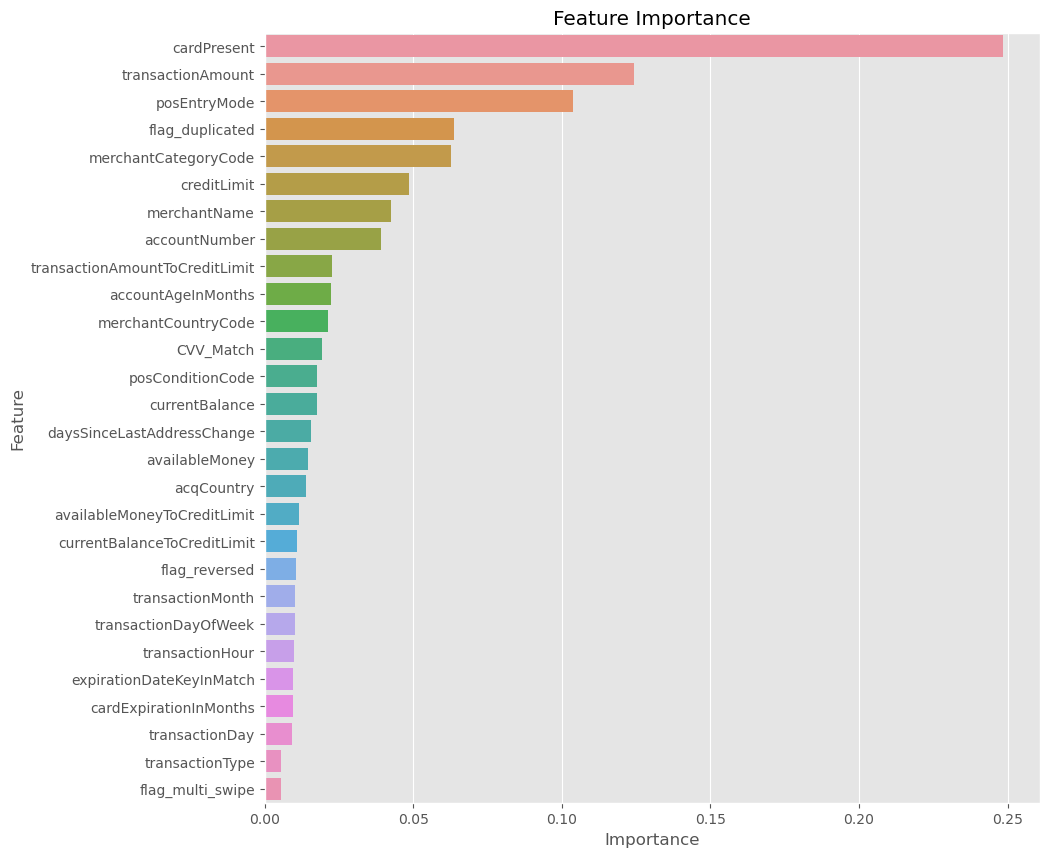

In [124]:
feature_importance_df = func.plot_feature_importance(xgb_normal,feature_names=X_columns)

In [125]:
models = [model_1, model_2]

df_models = pd.DataFrame(models)
df_models

,Model,Recall,FPR,AUC,ACC,precision,F1,KS
0,XGB,0.706785,0.210669,0.748058,0.788031,0.050930,0.095013,0.496116
1,XGB_Threshold,0.889338,0.460997,0.714170,0.544518,0.029934,0.057918,0.428340


## Train & Evaluate CatBoost Model

In [34]:
CAT_OPTUNA = False

In [35]:
cat_features=[]
if CAT_OPTUNA:
    # Define objective function for Optuna
    def objective(trial):
        # Define hyperparameters to search
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
            'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
            'eval_metric': 'Recall',
            'verbose': False,
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'task_type': 'GPU'  # Use GPU for training
        }

        # Create training and validation pools
        train_pool = Pool(X_train, y_train, cat_features=cat_features)
        val_pool = Pool(X_test, y_test, cat_features=cat_features)

        # Train CatBoost model with current hyperparameters
        clf = CatBoostClassifier(**params)
        clf.fit(train_pool, eval_set=val_pool, verbose=300)

        # Calculate evaluation metric on validation set
        auc = clf.get_best_score()['validation']['Recall']
        print(clf.get_best_score()['validation'])
        return auc

    # Optimize hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    # Get best hyperparameters
    best_params = study.best_params
    print("Best Hyperparameters:", best_params)
else:
    best_params_cat =  {'learning_rate': 0.07946132994112072, 'depth': 6, 'l2_leaf_reg': 8.874937226691701, 'bagging_temperature': 0.3767556736613058, 'iterations': 975}

In [36]:
# Create training and validation pools
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_test, y_test, cat_features=cat_features)

# Train final model with best hyperparameters
catboost_normal = CatBoostClassifier(**best_params_cat,verbose=False)
catboost_normal.fit(train_pool, eval_set=val_pool, verbose=300)
y_pred_cb = catboost_normal.predict(X_test)

normal_cat_acc = accuracy_score(y_test, y_pred_cb)

print("Test ACC:", normal_cat_acc)

0:	learn: 0.6790596	test: 0.6790296	best: 0.6790296 (0)	total: 303ms	remaining: 4m 54s
300:	learn: 0.4627772	test: 0.4740154	best: 0.4740154 (300)	total: 47.8s	remaining: 1m 47s
600:	learn: 0.4113668	test: 0.4285661	best: 0.4285661 (600)	total: 1m 34s	remaining: 58.8s
900:	learn: 0.3718747	test: 0.3934867	best: 0.3934867 (900)	total: 2m 24s	remaining: 11.9s
974:	learn: 0.3633797	test: 0.3863059	best: 0.3863059 (974)	total: 2m 37s	remaining: 0us

bestTest = 0.3863059182
bestIteration = 974

Test ACC: 0.8280569455659903


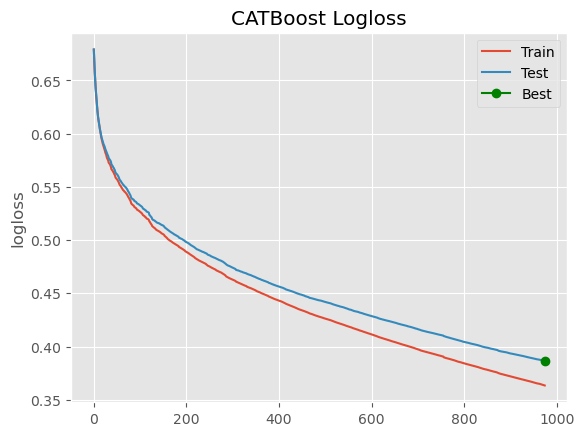

In [37]:
results = catboost_normal.get_evals_result()
val_mlogloss = results["validation"]['Logloss']
best_epopch = min(val_mlogloss)
i_best_epoch = val_mlogloss.index(best_epopch)
epochs = len(results['learn']['Logloss'])
x_axis = range(0, epochs)
    
# plot m log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['learn']['Logloss'], label='Train')
ax.plot(x_axis, results['validation']['Logloss'], label='Test')
ax.plot(i_best_epoch, best_epopch, marker="o", color="green", label="Best")
ax.legend()
plt.ylabel('logloss')
plt.title('CATBoost Logloss')
plt.show()

Test AUC: 0.761273127366078

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90    154719
           1       0.06      0.69      0.12      2554

    accuracy                           0.83    157273
   macro avg       0.53      0.76      0.51    157273
weighted avg       0.98      0.83      0.89    157273



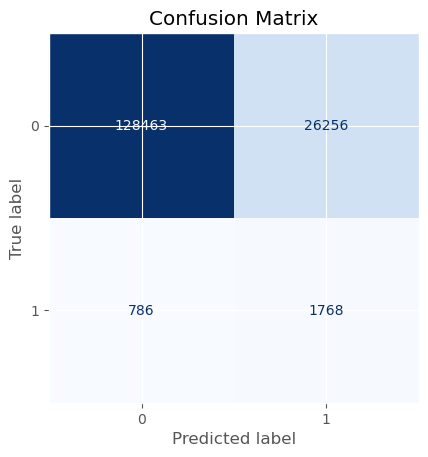

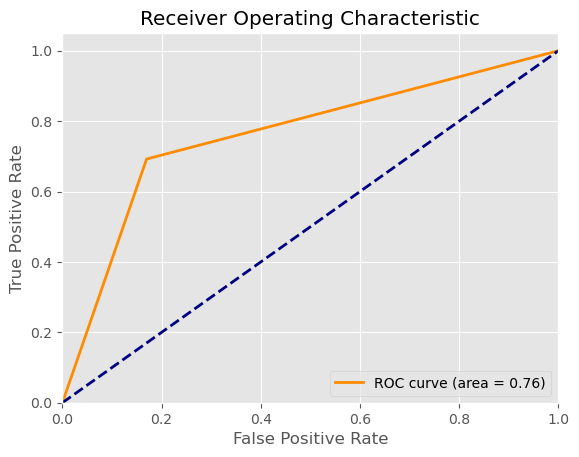

In [38]:
func.evaluate_model(y_test, y_pred_cb)

In [39]:
model_3 = func.dict_eval(y_test,y_pred_cb,'CATBOOST')

In [40]:
threshold = 0.23 #Adjust as you want 
y_pred_cat_proba = catboost_normal.predict_proba(X_test)
y_proba_cat = y_pred_cat_proba[:, 1]
y_pred_cb_t = (y_proba_cat >=threshold ).astype(int)

print(f"Recall : {recall_score(y_test,y_pred_cb_t)}")
print(f"Accuracy: {accuracy_score(y_test,y_pred_cb_t)}")

Recall : 0.9072043852779953
Accuracy: 0.5326089029903416


Test AUC: 0.7168148555957128

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.53      0.69    154719
           1       0.03      0.91      0.06      2554

    accuracy                           0.53    157273
   macro avg       0.51      0.72      0.37    157273
weighted avg       0.98      0.53      0.68    157273



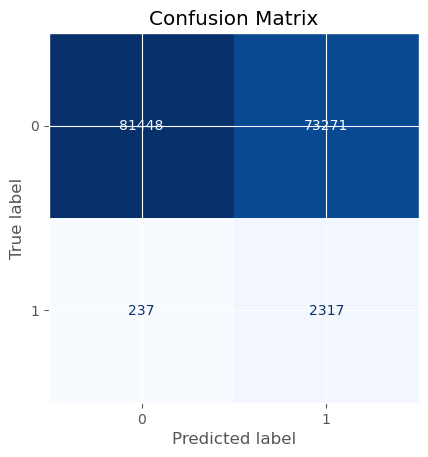

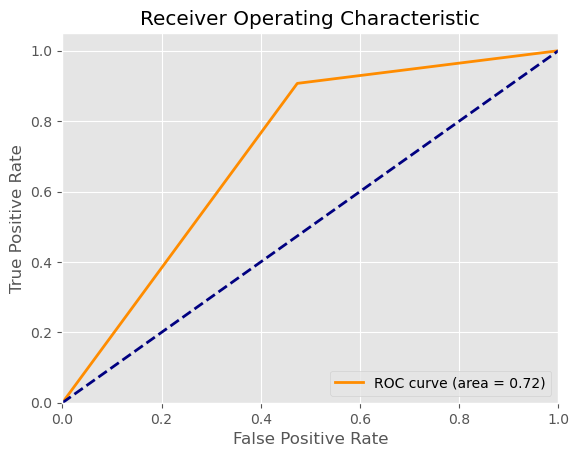

In [41]:
func.evaluate_model(y_test, y_pred_cb_t)

In [42]:
model_4 = func.dict_eval(y_test, y_pred_cb_t, 'CATBOOST_Threshold')

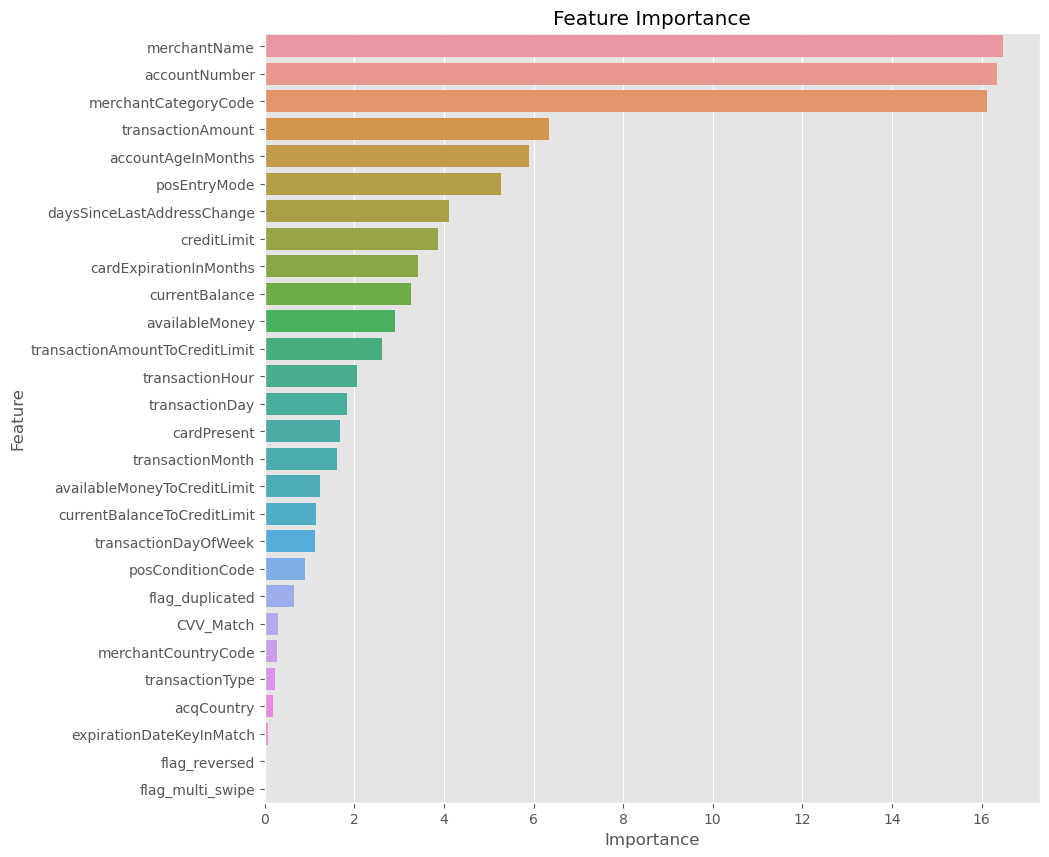

In [43]:
feature_importance_df = func.plot_feature_importance(catboost_normal, feature_names=X_columns)

In [44]:
models = [model_1, model_2, model_3, model_4]

df_models = pd.DataFrame(models)
df_models

,Model,Recall,FPR,AUC,ACC,precision,F1,KS
0,XGB,0.722788,0.211816,0.755486,0.787122,0.053325,0.099322,0.510972
1,XGB_Threshold,0.948316,0.602531,0.672893,0.406414,0.025323,0.049328,0.345785
2,CATBOOST,0.692247,0.169701,0.761273,0.828057,0.063089,0.115639,0.522546
3,CATBOOST_Threshold,0.907204,0.473575,0.716815,0.532609,0.030653,0.059302,0.433630


## Train & Evaluate Logistic Regression

In [45]:
# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [46]:
# Make predictions
y_pred_lr = log_reg.predict(X_test)

Test AUC: 0.6503701499153013

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.65      0.79    154719
           1       0.03      0.65      0.06      2554

    accuracy                           0.65    157273
   macro avg       0.51      0.65      0.42    157273
weighted avg       0.98      0.65      0.78    157273



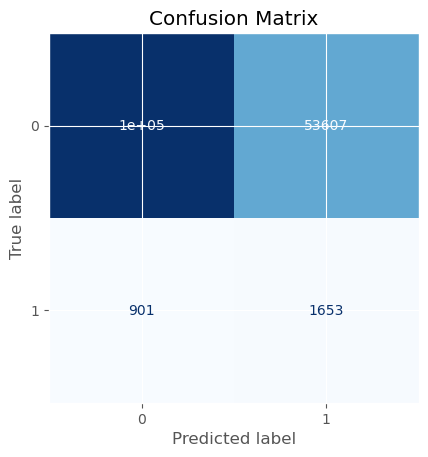

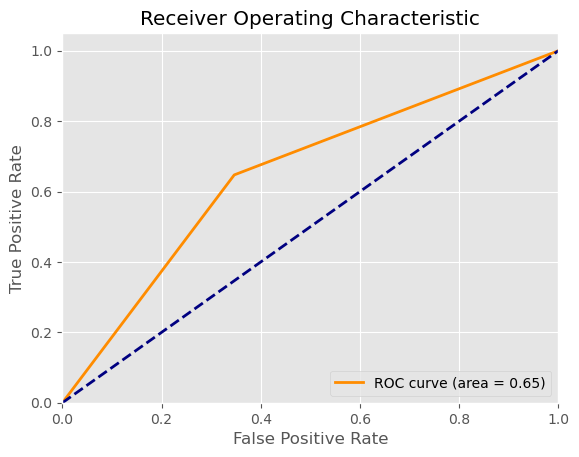

In [47]:
func.evaluate_model(y_test, y_pred_lr)

In [48]:
y_pred_lr

array([1, 1, 0, ..., 1, 0, 1])

In [49]:
model_5 = func.dict_eval(y_test, y_pred_lr, 'Logistic Regression')

In [50]:
models = [model_1, model_2, model_3, model_4, model_5]

df_models = pd.DataFrame(models)
df_models

,Model,Recall,FPR,AUC,ACC,precision,F1,KS
0,XGB,0.722788,0.211816,0.755486,0.787122,0.053325,0.099322,0.510972
1,XGB_Threshold,0.948316,0.602531,0.672893,0.406414,0.025323,0.049328,0.345785
2,CATBOOST,0.692247,0.169701,0.761273,0.828057,0.063089,0.115639,0.522546
3,CATBOOST_Threshold,0.907204,0.473575,0.716815,0.532609,0.030653,0.059302,0.433630
4,Logistic Regression,0.647220,0.346480,0.650370,0.653418,0.029913,0.057183,0.300740


## Train & Evaluate Random Forest

In [51]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [52]:
# Apply undersampling
# Count the number of samples in each class
class_counts = train_df['isFraud'].value_counts()

# Find the minority class label
minority_class = class_counts.idxmin()

# Find the number of samples in the minority class
minority_count = class_counts[minority_class]

# Find the number of samples in the majority class
majority_class = class_counts.idxmax()

# Sample the majority class to match the number of samples in the minority class
majority_sampled = train_df[train_df['isFraud'] == majority_class].sample(n=minority_count, replace=False, random_state=42)

# Combine minority class samples with the sampled majority class samples
undersampled_data = pd.concat([majority_sampled, train_df[train_df['isFraud'] == minority_class]])

# Shuffle the undersampled data
undersampled_data = undersampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

print("{0} Transaction in Sample Data ".format(undersampled_data.shape[0]))
print("{0} features in Sample Data ".format(undersampled_data.shape[1]))

train_df = undersampled_data.copy()

17332 Transaction in Sample Data 
29 features in Sample Data 


<Axes: xlabel='isFraud'>

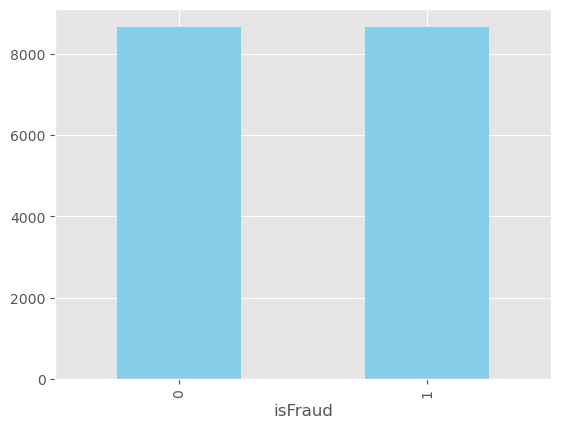

In [53]:
train_df['isFraud'].value_counts().plot(kind='bar', color='skyblue')

In [54]:
# Define Dependent and Independent Features
X_train = train_df.drop(['isFraud'],axis=1)
y_train = train_df[['isFraud']]

X_test = test_df.drop(['isFraud'],axis=1)
y_test = test_df[['isFraud']]

# Print the shapes of the resulting datasets
print("Shapes of training and testing sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print(y_train.value_counts())
# print(pd.Series(y_train).mean())
print(y_train['isFraud'].mean())

Shapes of training and testing sets:
X_train: (17332, 28)
y_train: (17332, 1)
X_test: (235909, 28)
y_test: (235909, 1)
isFraud
0          8666
1          8666
Name: count, dtype: int64
0.5


In [55]:
# Standardize the features using MinMaxScaler (between 0 to 1, more sensitive to outliers), rather than StandardScaler (between -1 to 1, less sensitivie)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
# grid searching key hyperparameters for RandomForestClassifier
Start_time= time.time()

# define models and parameters
RF = RandomForestClassifier()
n_estimators = [5, 10, 15]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators, max_features=max_features)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

RF_random_search = GridSearchCV(estimator=RF, param_grid=grid, cv=5, scoring='roc_auc')
RF_random_result = RF_random_search.fit(X_train_scaled, y_train)

# summarize results
print("Best: %f using %s" % (RF_random_result.best_score_, RF_random_result.best_params_))

Best: 0.764899 using {'max_features': 'sqrt', 'n_estimators': 15}


In [57]:
# check recall on test set
y_pred_rf = RF_random_result.predict(X_test)

In [58]:
model_6 = func.dict_eval(y_test['isFraud'], y_pred_rf, 'Random Forest')
model_6

{'Model': 'Random Forest',
 'Recall': 0.2559317515329246,
 'FPR': 0.3522514839032039,
 'AUC': 0.45184013381486043,
 'ACC': 0.6415185516449139,
 'precision': 0.011602891053687545,
 'F1': 0.02219935483125022,
 'KS': 0.09631973237027924}

In [59]:
models = [model_1, model_2, model_3, model_4, model_5, model_6]

df_models = pd.DataFrame(models)
df_models

,Model,Recall,FPR,AUC,ACC,precision,F1,KS
0,XGB,0.722788,0.211816,0.755486,0.787122,0.053325,0.099322,0.510972
1,XGB_Threshold,0.948316,0.602531,0.672893,0.406414,0.025323,0.049328,0.345785
2,CATBOOST,0.692247,0.169701,0.761273,0.828057,0.063089,0.115639,0.522546
3,CATBOOST_Threshold,0.907204,0.473575,0.716815,0.532609,0.030653,0.059302,0.433630
4,Logistic Regression,0.647220,0.346480,0.650370,0.653418,0.029913,0.057183,0.300740
5,Random Forest,0.255932,0.352251,0.451840,0.641519,0.011603,0.022199,0.096320


## Train & Evaluate Neural Network

- The neural network consists of three hidden layers with 64, 32, and 16 neurons respectively.
- Each layer uses the ReLU activation function, which introduces non-linearity into the model and helps it learn complex patterns.
- The output layer has a single neuron with a sigmoid activation function, which outputs a value between 0 and 1, representing the probability of a transaction being fraudulent.
- Use `SMOTEENN`, which combines SMOTE with Edited Nearest Neighbors (ENN) cleaning. This technique not only generates synthetic samples for the minority class but also removes noisy samples from both classes.
- The neural network now has four hidden layers with 256, 128, 64, and 32 neurons respectively
- Batch normalization layers have been added after each hidden layer to stabilize and speed up training.
- Dropout layers (with a dropout rate of 0.25) are added to prevent overfitting.
- **Loss Function:** Binary Cross-Entropy Loss (`BCELoss`) is used as the loss function, which is suitable for binary classification tasks.
- **Optimizer:** Adam optimizer is used for training the model. It combines the benefits of AdaGrad and RMSProp algorithms, providing an adaptive learning rate and faster convergence.

In [60]:
# !pip install torch

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [62]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 786362 entries, 541899 to 108114
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   accountNumber                   786362 non-null  int32  
 1   creditLimit                     786362 non-null  float64
 2   availableMoney                  786362 non-null  float64
 3   transactionAmount               786362 non-null  float64
 4   merchantName                    786362 non-null  int32  
 5   acqCountry                      786362 non-null  int32  
 6   merchantCountryCode             786362 non-null  int32  
 7   posEntryMode                    786362 non-null  int32  
 8   posConditionCode                786362 non-null  int32  
 9   merchantCategoryCode            786362 non-null  int32  
 10  cardPresent                     786362 non-null  int32  
 11  transactionType                 786362 non-null  int32  
 12  currentBalance  

In [64]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode']

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

In [65]:
df.isFraud = df.isFraud.astype(int) # Covert from from pool to int for the model 

In [66]:
# Select relevant features
features = ['transactionAmount', 'creditLimit', 'availableMoney', 'currentBalance',
            'transactionAmountToCreditLimit', 'availableMoneyToCreditLimit', 'currentBalanceToCreditLimit'] + categorical_columns
X = df[features]
y = df['isFraud']

In [67]:
print(X)
print(y)

        transactionAmount  creditLimit  availableMoney  currentBalance  \
541899             205.13      50000.0        50000.00            0.00   
541900              46.43      50000.0        49794.87          205.13   
541901             378.67      50000.0        49748.44          251.56   
541902              66.07      50000.0        50000.00            0.00   
541903             141.60      50000.0        49933.93           66.07   
...                   ...          ...             ...             ...   
108110             267.62       5000.0         4921.32           78.68   
108111               4.62       5000.0         4653.70          346.30   
108112               4.62       5000.0         4674.08          325.92   
108113               4.62       5000.0         4694.46          305.54   
108114               4.62       5000.0         4714.84          285.16   

        transactionAmountToCreditLimit  availableMoneyToCreditLimit  \
541899                        0.004103  

In [68]:
# Print the unique values for columns less than 20 unique values
for i in X.columns:
    if X[i].nunique() < 20:
        print(i, X[i].unique())
        print('-'*20)

creditLimit [50000.  5000. 20000.   250.  1000.  2500.  7500. 10000.   500. 15000.]
--------------------
acqCountry [4 0 1 2 3]
--------------------
merchantCountryCode [4 0 1 2 3]
--------------------
posEntryMode [1 2 3 0 4 5]
--------------------


In [69]:
X.head()

,transactionAmount,creditLimit,availableMoney,currentBalance,transactionAmountToCreditLimit,availableMoneyToCreditLimit,currentBalanceToCreditLimit,merchantName,acqCountry,merchantCountryCode,posEntryMode
541899,205.13,50000.0,50000.00,0.00,0.004103,1.000000,0.000000,1974,4,4,1
541900,46.43,50000.0,49794.87,205.13,0.000929,0.995897,0.004103,1784,4,4,2
541901,378.67,50000.0,49748.44,251.56,0.007573,0.994969,0.005031,148,4,4,2
541902,66.07,50000.0,50000.00,0.00,0.001321,1.000000,0.000000,1967,4,4,1
541903,141.60,50000.0,49933.93,66.07,0.002832,0.998679,0.001321,446,4,4,3


In [70]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 786362 entries, 541899 to 108114
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   transactionAmount               786362 non-null  float64
 1   creditLimit                     786362 non-null  float64
 2   availableMoney                  786362 non-null  float64
 3   currentBalance                  786362 non-null  float64
 4   transactionAmountToCreditLimit  786362 non-null  float64
 5   availableMoneyToCreditLimit     786362 non-null  float64
 6   currentBalanceToCreditLimit     786362 non-null  float64
 7   merchantName                    786362 non-null  int32  
 8   acqCountry                      786362 non-null  int32  
 9   merchantCountryCode             786362 non-null  int32  
 10  posEntryMode                    786362 non-null  int32  
dtypes: float64(7), int32(4)
memory usage: 60.0 MB


In [71]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [72]:
# # It takes too long. CUDA toolkit needs to be installed with good GPUs
# # Apply SMOTEENN to the training data
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

In [73]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [74]:
# Print the shapes of the resulting datasets
print("Shapes of training and testing sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print(y_train.value_counts())
print(pd.Series(y_train).mean())
# print(pd.Series(y_train).mean())
# print(y_train['isFraud'].mean())
print("--"*20)
print("X_train:", X_train_resampled.shape)
print("y_train:", y_train_resampled.shape)
print(y_train_resampled.value_counts())
print(pd.Series(y_train_resampled).mean())
# print(y_train_resampled['isFraud'].mean())

Shapes of training and testing sets:
X_train: (550453, 11)
y_train: (550453,)
X_test: (235909, 11)
y_test: (235909,)
isFraud
0    541787
1      8666
Name: count, dtype: int64
0.01574339680227013
----------------------------------------
X_train: (1083574, 11)
y_train: (1083574,)
isFraud
0    541787
1    541787
Name: count, dtype: int64
0.5


In [75]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 550453 entries, 290523 to 54301
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   transactionAmount               550453 non-null  float64
 1   creditLimit                     550453 non-null  float64
 2   availableMoney                  550453 non-null  float64
 3   currentBalance                  550453 non-null  float64
 4   transactionAmountToCreditLimit  550453 non-null  float64
 5   availableMoneyToCreditLimit     550453 non-null  float64
 6   currentBalanceToCreditLimit     550453 non-null  float64
 7   merchantName                    550453 non-null  int32  
 8   acqCountry                      550453 non-null  int32  
 9   merchantCountryCode             550453 non-null  int32  
 10  posEntryMode                    550453 non-null  int32  
dtypes: float64(7), int32(4)
memory usage: 42.0 MB


In [76]:
# Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Define the neural network architecture
class FraudDetectionModel(nn.Module):
    def __init__(self, input_dim):
        super(FraudDetectionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
model = FraudDetectionModel(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor)
    y_pred_nn_class = y_pred_nn.round()

Epoch [1/30], Loss: 46.0570
Epoch [2/30], Loss: 41.5990
Epoch [3/30], Loss: 29.7742
Epoch [4/30], Loss: 9.8784
Epoch [5/30], Loss: 7.1745
Epoch [6/30], Loss: 21.5819
Epoch [7/30], Loss: 24.6380
Epoch [8/30], Loss: 21.8159
Epoch [9/30], Loss: 9.2189
Epoch [10/30], Loss: 8.9224
Epoch [11/30], Loss: 8.3408
Epoch [12/30], Loss: 5.5940
Epoch [13/30], Loss: 13.1399
Epoch [14/30], Loss: 12.1698
Epoch [15/30], Loss: 4.7459
Epoch [16/30], Loss: 4.5641
Epoch [17/30], Loss: 3.4784
Epoch [18/30], Loss: 7.2439
Epoch [19/30], Loss: 9.8993
Epoch [20/30], Loss: 6.2338
Epoch [21/30], Loss: 2.6515
Epoch [22/30], Loss: 2.2796
Epoch [23/30], Loss: 5.0091
Epoch [24/30], Loss: 5.2575
Epoch [25/30], Loss: 2.6299
Epoch [26/30], Loss: 2.2383
Epoch [27/30], Loss: 3.4068
Epoch [28/30], Loss: 3.9015
Epoch [29/30], Loss: 2.9556
Epoch [30/30], Loss: 1.4882


In [77]:
# Calculate evaluation metrics
print("Classification Report:\n", classification_report(y_test_tensor.cpu(), y_pred_nn_class.cpu()))
print("Confusion Matrix:\n", confusion_matrix(y_test_tensor.cpu(), y_pred_nn_class.cpu()))
print("AUC-ROC Score:\n", roc_auc_score(y_test_tensor.cpu(), y_pred_nn.cpu()))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.25      0.40    232158
         1.0       0.02      0.83      0.03      3751

    accuracy                           0.26    235909
   macro avg       0.50      0.54      0.22    235909
weighted avg       0.97      0.26      0.40    235909

Confusion Matrix:
 [[ 59105 173053]
 [   644   3107]]
AUC-ROC Score:
 0.5745215370325446


In [78]:
y_pred_nn_class.unique()

tensor([0., 1.])

Test AUC: 0.5414509983937547

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.25      0.40    232158
           1       0.02      0.83      0.03      3751

    accuracy                           0.26    235909
   macro avg       0.50      0.54      0.22    235909
weighted avg       0.97      0.26      0.40    235909



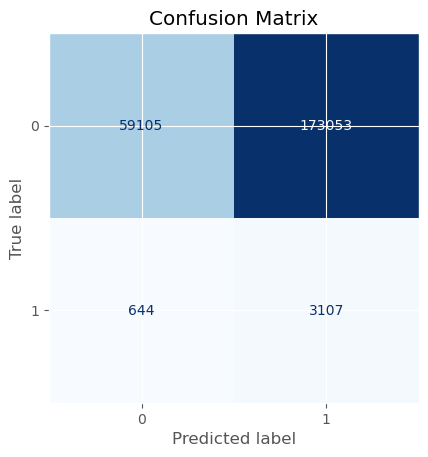

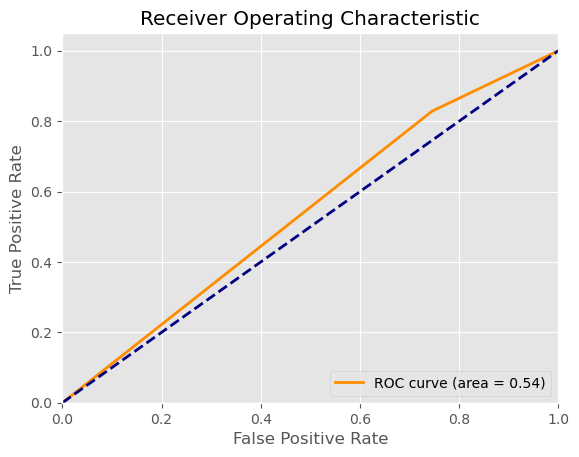

In [79]:
func.evaluate_model(y_test, y_pred_nn_class)

In [80]:
print(y_test.unique())
print(y_pred_nn_class.unique())

[0 1]
tensor([0., 1.])


In [81]:
# Create the tensor
# tensor_data = torch.tensor([0., 1.])

# Convert to NumPy array and cast to integer type
y_pred_nn_array = y_pred_nn_class.numpy().astype(int).ravel()

# Convert to Pandas Series
y_pred_nn_series = pd.Series(y_pred_nn_array)

print(y_pred_nn_series.unique())

[1 0]


In [82]:
y_pred_nn_array

array([1, 1, 1, ..., 1, 1, 1])

In [83]:
# model_8 = func.dict_eval(y_test, y_pred_nn_class, 'Neural Network')
model_7 = func.dict_eval(y_test, y_pred_nn_array, 'Neural Network')
model_7

{'Model': 'Neural Network',
 'Recall': 0.8283124500133298,
 'FPR': 0.7454104532258203,
 'AUC': 0.5414509983937547,
 'ACC': 0.2637118549949345,
 'precision': 0.017637375113533152,
 'F1': 0.0345392999872159,
 'KS': 0.08290199678750945}

In [126]:
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]

df_models = pd.DataFrame(models)
df_models

,Model,Recall,FPR,AUC,ACC,precision,F1,KS
0,XGB,0.706785,0.210669,0.748058,0.788031,0.050930,0.095013,0.496116
1,XGB_Threshold,0.889338,0.460997,0.714170,0.544518,0.029934,0.057918,0.428340
2,CATBOOST,0.692247,0.169701,0.761273,0.828057,0.063089,0.115639,0.522546
3,CATBOOST_Threshold,0.907204,0.473575,0.716815,0.532609,0.030653,0.059302,0.433630
4,Logistic Regression,0.647220,0.346480,0.650370,0.653418,0.029913,0.057183,0.300740
5,Random Forest,0.255932,0.352251,0.451840,0.641519,0.011603,0.022199,0.096320
6,Neural Network,0.828312,0.745410,0.541451,0.263712,0.017637,0.034539,0.082902


## Save the Models and Final Data

In [85]:
pickle.dump([xgb_normal, catboost_normal, log_reg, RF_random_search, model, train_df, test_df], open("model_data.pickle", "wb"))

In [86]:
# ## When you read the models and data from the pickle
# xgb_normal, catboost_normal, log_reg, RF_random_search, model, train_df, test_df = pickle.load(open("model_data.pickle", "rb"))

Different version of saving models

In [87]:
# !conda install dill -y
# import dill
# dill.dump_session('fraud_detection_models.pkl')

In [88]:
# ##  read saved models
# infile = open('fraud_detection_models','rb')
# saved_models = pickle.load(infile)
# models_to_save = saved_models.copy() # save new models in this new dict
# infile.close()
# print('models loaded:\n', saved_models.keys())